泰坦尼克号数据预测

In [1]:
# 使用tf.keras搭建回归模型，数据集使用加利福尼亚的房价预测
#导入必要的库即版本

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras
#import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd,sklearn,tf,keras:
    print(module.__name__, module.__version__)

2.0.0-beta1
sys.version_info(major=3, minor=7, micro=0, releaselevel='final', serial=0)
matplotlib 2.2.3
numpy 1.16.4
pandas 0.23.4
sklearn 0.19.2
tensorflow 2.0.0-beta1
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [3]:
# 数据文件路径
train_file = './data/titanic/train.csv'
eval_file = './data/titanic/eval.csv'

# 读取数据
train_df = pd.read_csv(train_file)
eval_df = pd.read_csv(eval_file)

print(train_df.head())
print(eval_df.head())

   survived     sex   age  n_siblings_spouses  parch     fare  class     deck  \
0         0    male  22.0                   1      0   7.2500  Third  unknown   
1         1  female  38.0                   1      0  71.2833  First        C   
2         1  female  26.0                   0      0   7.9250  Third  unknown   
3         1  female  35.0                   1      0  53.1000  First        C   
4         0    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
   survived     sex   age  n_siblings_spouses  parch     fare   class  \
0         0    male  35.0                   0      0   8.0500   Third   
1         0    male  54.0                   0      0  51.8625   First   
2         1  female  58.0                   0      0  26.5500   First   
3         1  female  55.0                   0      0  16.0000  Second   
4         

In [5]:
# 提取特征和标签
y_train = train_df.pop('survived')
y_eval = eval_df.pop('survived')

print(train_df.head())
print(eval_df.head())
print(y_train.head())
print(y_eval.head())

      sex   age  n_siblings_spouses  parch     fare  class     deck  \
0    male  22.0                   1      0   7.2500  Third  unknown   
1  female  38.0                   1      0  71.2833  First        C   
2  female  26.0                   0      0   7.9250  Third  unknown   
3  female  35.0                   1      0  53.1000  First        C   
4    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
      sex   age  n_siblings_spouses  parch     fare   class     deck  \
0    male  35.0                   0      0   8.0500   Third  unknown   
1    male  54.0                   0      0  51.8625   First        E   
2  female  58.0                   0      0  26.5500   First        C   
3  female  55.0                   0      0  16.0000  Second  unknown   
4    male  34.0                   0      0  13.0000  Second        D   

  

In [6]:
# 数据中的统计量
train_df.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [7]:
print(train_df.shape, eval_df.shape)

(627, 9) (264, 9)


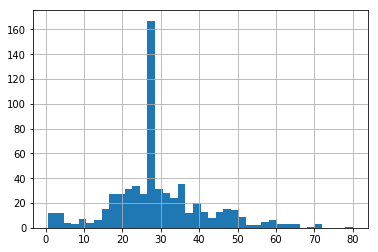

In [9]:
# 画直方图
train_df.age.hist(bins=40)

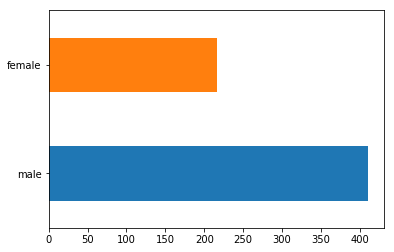

In [10]:
# 统计各种值的个数,并绘制柱状图，横向柱状图参数“barh”,纵向柱状图“barv”
train_df.sex.value_counts().plot(kind='barh')

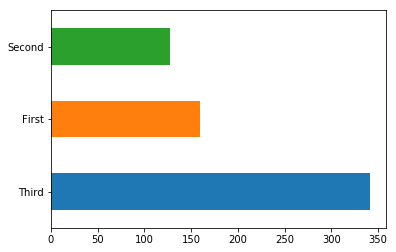

In [13]:
train_df['class'].value_counts().plot(kind='barh')

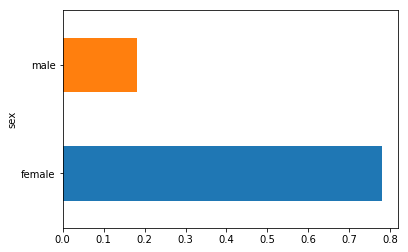

In [15]:
# 统计男性获救比例，女性获救比例，并绘制柱状图
# 先合并（concat）数据，然后对sex使用groupby，再根据survived求均值
pd.concat([train_df,y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh')

In [16]:
# 将特征分为离散特征和连续特征
categorical_columns = ['sex', 'n_siblings_spouses','parch', 'class', 'deck', 
                      'embark_town', 'alone']
numeric_columns = ['age', 'fare']

feature_columns = []
for categorical_column in categorical_columns:
    # 获取单独特征所有可能的值
    vocab = train_df[categorical_column].unique()
    print(categorical_column,vocab)
    # 进行one-hot编码,tf.feature_column.indicator_column
    feature_columns.append(tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            categorical_column,vocab)))
    
for numeric_column in numeric_columns:
    # 连续特征，直接加载
    feature_columns.append(
        tf.feature_column.numeric_column(
            numeric_column,dtype=tf.float32))
    
    
    
    

sex ['male' 'female']
n_siblings_spouses [1 0 3 4 2 5 8]
parch [0 1 2 5 3 4]
class ['Third' 'First' 'Second']
deck ['unknown' 'C' 'G' 'A' 'B' 'D' 'F' 'E']
embark_town ['Southampton' 'Cherbourg' 'Queenstown' 'unknown']
alone ['n' 'y']


In [19]:
# 构建dataset
def make_dataset(data_df, label_df, epochs=10, shuffle=True,
                batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
        dataset = dataset.shuffle(10000)
        
    dataset = dataset.repeat(epochs).batch(batch_size)
    return dataset

In [20]:
train_dataset = make_dataset(train_df, y_train, batch_size=5)

In [26]:
for x,y in train_dataset.take(1):
    print(x,y)
    print(x.keys())

{'sex': <tf.Tensor: id=796, shape=(5,), dtype=string, numpy=array([b'female', b'female', b'male', b'male', b'female'], dtype=object)>, 'age': <tf.Tensor: id=788, shape=(5,), dtype=float64, numpy=array([34., 33.,  1., 28., 36.])>, 'n_siblings_spouses': <tf.Tensor: id=794, shape=(5,), dtype=int32, numpy=array([0, 1, 1, 0, 1])>, 'parch': <tf.Tensor: id=795, shape=(5,), dtype=int32, numpy=array([0, 2, 2, 0, 0])>, 'fare': <tf.Tensor: id=793, shape=(5,), dtype=float64, numpy=array([10.5  , 27.75 , 20.575,  0.   , 26.   ])>, 'class': <tf.Tensor: id=790, shape=(5,), dtype=string, numpy=array([b'Second', b'Second', b'Third', b'Second', b'Second'], dtype=object)>, 'deck': <tf.Tensor: id=791, shape=(5,), dtype=string, numpy=array([b'F', b'unknown', b'unknown', b'unknown', b'unknown'], dtype=object)>, 'embark_town': <tf.Tensor: id=792, shape=(5,), dtype=string, numpy=
array([b'Southampton', b'Southampton', b'Southampton', b'Southampton',
       b'Southampton'], dtype=object)>, 'alone': <tf.Tensor:

In [23]:
# 将dataset与feature_columns联系起来
# keras.layers.DenseFeature
for x,y in train_dataset.take(1):
    age_cloumn = feature_columns[7]
    print(age_cloumn)
    gender_column =feature_columns[0]
    print(keras.layers.DenseFeatures(age_cloumn)(x).numpy())
    print(keras.layers.DenseFeatures(gender_column)(x).numpy())

NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
[[34.]
 [33.]
 [ 1.]
 [28.]
 [36.]]
[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [25]:
# 将dataset与feature_columns联系起来
# keras.layers.DenseFeature,one-hot编码后特征不再是原来9个
for x,y in train_dataset.take(1):
    print(keras.layers.DenseFeatures(feature_columns)(x).numpy())

[[34.     0.     1.     0.     0.     1.     0.     0.     0.     0.
   0.     0.     1.     0.     1.     0.     0.     0.    10.5    0.
   1.     0.     0.     0.     0.     0.     1.     0.     0.     0.
   0.     0.     0.     1.   ]
 [33.     1.     0.     0.     0.     1.     1.     0.     0.     0.
   0.     0.     0.     0.     1.     0.     0.     0.    27.75   1.
   0.     0.     0.     0.     0.     0.     0.     0.     1.     0.
   0.     0.     0.     1.   ]
 [ 1.     1.     0.     1.     0.     0.     1.     0.     0.     0.
   0.     0.     0.     0.     1.     0.     0.     0.    20.575  1.
   0.     0.     0.     0.     0.     0.     0.     0.     1.     0.
   0.     0.     1.     0.   ]
 [28.     0.     1.     0.     0.     1.     1.     0.     0.     0.
   0.     0.     0.     0.     1.     0.     0.     0.     0.     0.
   1.     0.     0.     0.     0.     0.     1.     0.     0.     0.
   0.     0.     1.     0.   ]
 [36.     1.     0.     0.     0.     1.     1. 

In [27]:
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(2, activation='softmax'),
])
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=keras.optimizers.SGD(lr=0.01),
             metrics=['accuracy'])


In [28]:
# 1、model.fit
# 2、model -> estimator ->train

train_dataset = make_dataset(train_df, y_train, epochs=100)
eval_dateset = make_dataset(eval_df, y_eval, epochs=1,shuffle=False)
history = model.fit(train_dataset,
                    validation_data=eval_dateset,
                    steps_per_epoch=20,
                    validation_steps=8,
                    epochs=100

)

Epoch 1/100
20/20 [==============================] - 2s 80ms/step - loss: 1.3645 - accuracy: 0.5549 - val_loss: 0.8437 - val_accuracy: 0.6992
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 0.9603 - accuracy: 0.6384 - val_loss: 0.6173 - val_accuracy: 0.6992
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 0.7316 - accuracy: 0.6330 - val_loss: 0.6738 - val_accuracy: 0.6172
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 0.7232 - accuracy: 0.6482 - val_loss: 0.5925 - val_accuracy: 0.6875
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.6517 - val_loss: 0.6122 - val_accuracy: 0.6875
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5957 - accuracy: 0.7049 - val_loss: 0.6214 - val_accuracy: 0.6562
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6199 - accuracy: 0.6884 - val_loss: 0.5914 - val_accuracy: 0.6914
Epoch 8/100


Epoch 59/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5613 - accuracy: 0.7113 - val_loss: 0.5892 - val_accuracy: 0.7070
Epoch 60/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5338 - accuracy: 0.7251 - val_loss: 0.5195 - val_accuracy: 0.7617
Epoch 61/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5590 - accuracy: 0.7198 - val_loss: 0.5454 - val_accuracy: 0.7305
Epoch 62/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5535 - accuracy: 0.7548 - val_loss: 0.5749 - val_accuracy: 0.6445
Epoch 63/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5381 - accuracy: 0.7611 - val_loss: 0.5158 - val_accuracy: 0.7109
Epoch 64/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5317 - accuracy: 0.7421 - val_loss: 0.5663 - val_accuracy: 0.7383
Epoch 65/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4844 - accuracy: 0.8017 - val_loss: 0.5138 - val_accuracy: 0.7227
Epoch 

W0817 13:49:44.559439 18836 training_generator.py:235] Your dataset ran out of data; interrupting training. Make sure that your dataset can generate at least `steps_per_epoch * epochs` batches (in this case, 2000 batches). You may need to use the repeat() function when building your dataset.


Epoch 99/100
 0/20 [..............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00

In [31]:
# 将keras模型转为estimator
estimator = keras.estimator.model_to_estimator(model)
# estimator训练模型,
# 参数input_fn是一个函数，可以是具体函数，也可以是lambda生成的匿名函数，
# 函数返回（features，labels）组成的元组，features、labels可以是列表，也可以是numpy数组
# 也可以返回一个dataset，dataset->(feature,label)
estimator.train(input_fn=lambda:make_dataset(
    train_df,y_train,epochs=100))
# 报错，tensorflow2.0的框架bug

W0817 13:56:51.772914 18836 estimator.py:1811] Using temporary folder as model directory: C:\Users\段云琦\AppData\Local\Temp\tmpm9brb5rs
W0817 13:56:51.774909 18836 keras.py:564] You are creating an Estimator from a Keras model manually subclassed from `Model`, that was already called on some inputs (and thus already had weights). We are currently unable to preserve the model's state (its weights) as part of the estimator in this case. Be warned that the estimator has been created using a freshly initialized version of your model.
Note that this doesn't affect the state of the model instance you passed as `keras_model` argument.


KeyError: "The dictionary passed into features does not have the expected inputs keys defined in the keras model.\n\tExpected keys: {'input_2', 'input_1', 'input_6', 'input_9', 'input_7', 'input_8', 'input_3', 'input_4', 'input_5'}\n\tfeatures keys: {'age', 'fare', 'n_siblings_spouses', 'deck', 'sex', 'alone', 'embark_town', 'class', 'parch'}\n\tDifference: {'age', 'input_2', 'fare', 'n_siblings_spouses', 'deck', 'input_1', 'input_6', 'input_9', 'input_7', 'sex', 'alone', 'input_8', 'embark_town', 'input_3', 'input_4', 'class', 'parch', 'input_5'}"